In [1]:
import numpy as np
import scanpy as sc
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import sys
from sklearn import metrics
import PROST
PROST.__version__

' 1.1.2 '

In [2]:
#%% init
SEED = 818
PROST.setup_seed(SEED)

# Set directory (If you want to use additional data, please change the file path)
rootdir = 'datasets/osmFISH/'

input_dir = os.path.join(rootdir)
output_dir = os.path.join(rootdir, 'results/')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [3]:
# Read oringal data
adata = sc.read_loom(input_dir + 'osmFISH_SScortex_mouse_all_cells.loom')

# Read used cells from oringal data
used_cells = adata.obs.Region != 'Excluded'
used_cells = pd.DataFrame(used_cells).reset_index()
used_cell_ID = used_cells[used_cells['Region']]['CellID']
used_cell_ID = list(used_cell_ID)

# Filter oringal data
adata = adata[adata.obs.Region!='Excluded',]

# Read simulated data
simcount = pd.read_csv(input_dir + "/Dataset5_counts1.txt",delim_whitespace=True)
simcount.columns = [str(x)[5:] for x in simcount.columns]
sim_adata = sc.AnnData(simcount.T)

# Read simulated annotation
sim_annotation = pd.read_csv(input_dir + "/Dataset5_true_cl1.csv",index_col=0)
sim_adata.obs['annotation'] = sim_annotation.values
sim_adata.obs['annotation'] = sim_adata.obs['annotation'].astype('category')

# Filter simulated data
for i in sim_adata.obs_names:
    if i in used_cell_ID:
        sim_adata.obs.loc[i,'keep'] = True
sim_adata.obs['keep'] = sim_adata.obs['keep'].fillna(False)
sim_adata = sim_adata[sim_adata.obs.keep,:]

# Read location information from oringal data
sim_adata.obsm['spatial'] = adata.obs[['X','Y']].values

# Save simulated adata
sim_adata.write_h5ad(output_dir + "sim_adata.h5")

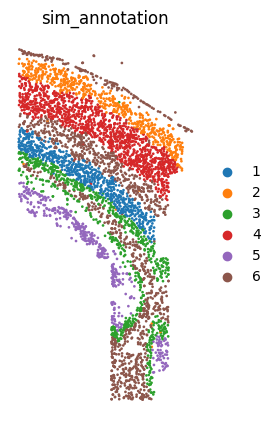

In [4]:
# Plot simulated annotation
adata = sc.read(output_dir + "sim_adata.h5")
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="annotation", size = 15, show=False, title='sim_annotation')
plt.axis('off')
plt.gca().set_aspect('equal', 'box')
plt.savefig(output_dir+"sim_annotation.png", dpi=600, bbox_inches='tight')

In [5]:
#%% Clustering
PROST.setup_seed(SEED)
adata = sc.read(output_dir + "sim_adata.h5")

# 1.Expression data preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# 3.Run PROST
PROST.run_PNN(adata, 
                platform="osmFISH", 
                min_distance = 275,
                init="mclust",
                n_clusters = 6,
                tol = 5e-3,
                SEED=SEED,
                max_epochs = 100,
                post_processing = True,
                pp_run_times = 1)


# Calculate ARI
ARI = metrics.adjusted_rand_score(adata.obs["annotation"], adata.obs["pp_clustering"])
print("clustering_ARI=", ARI)


Calculating adjacency matrix ...

Running PCA ...
Laplacian Smoothing ...

Initializing cluster centers with mclust, n_clusters known


Epoch: : 102it [02:36,  1.54s/it, loss=0.14192994]                                                                     


Clustering completed !!

Post-processing for clustering result ...
Refining clusters, run times: 1/1
clustering_ARI= 0.9041096401232858


In [6]:
# Save result
pp_clustering = adata.obs["pp_clustering"] 
embedding = adata.obsm["PROST"]

pp_clustering.to_csv(output_dir + "pp_clustering_sim.csv",header = False)
adata.write_h5ad(output_dir + "PNN_result_sim.h5")
np.savetxt(output_dir + "embedding_sim.txt",embedding)


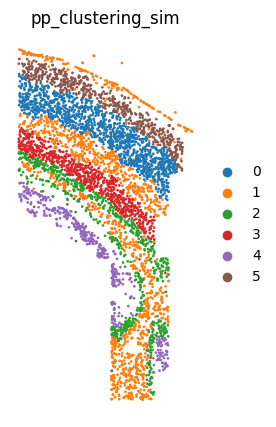

In [7]:
# Plot cluster result
adata = sc.read(output_dir + "PNN_result_sim.h5")

#
plt.rcParams["figure.figsize"] = (5,5)
sc.pl.embedding(adata, basis="spatial", color="pp_clustering", size = 15, show=False, title='pp_clustering_sim')
plt.axis('off')
plt.gca().set_aspect('equal', 'box')
plt.savefig(output_dir+"pp_clustering_sim.png", dpi=600, bbox_inches='tight')